#Data Exploration

##Imports

In [ ]:
# Download and import of German Stopwords, execution only needed once
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [14]:
# All necessary imports
import pandas as pd
import numpy as np
# import time
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from matplotlib.colors import LogNorm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from langdetect import detect, DetectorFactory
from ast import literal_eval
from fuzzywuzzy import fuzz

##Data prep

In [2]:
# Loading synonyms into a dataframe
kode = pd.read_excel("kode_data.xlsx", header=1)

# Keep one of the df commented:

# Reading full dataset into dataframe
df = pd.read_csv('jobs.csv', encoding='UTF-8')

# Reading sample dataset into dataframe
# df = pd.read_excel("jobs_sample.xlsx")

In [3]:
# Dropping english offers
# print(df.shape)

# DetectorFactory.seed = 0

# for index, row in df.iterrows():
#     try:
#         if detect(row['profile'][:row['profile'].find('.')]) != 'de':
#             df.drop(index, inplace=True)
#     except:
#         pass


# print(df.shape)

##Work type distribution

Vollzeit       344826
Teilzeit        22521
Home Office        43
Name: work_type, dtype: int64


Text(0.5, 1.0, 'work_type Verteilung in %')

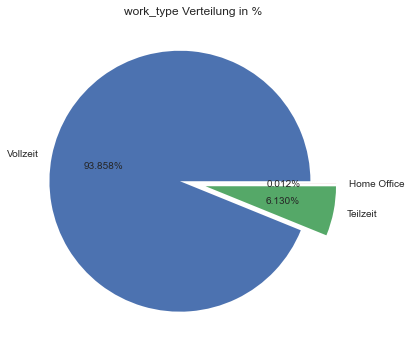

In [4]:
# Auf welcher Basis wird Arbeit geboten (Vollzeit, etc.)?

worktype_cnt = df['work_type'].value_counts()
print(worktype_cnt)

pie, ax = plt.subplots(figsize=[10,6])
pie.set_facecolor('white')
plt.pie(worktype_cnt, autopct="%.3f%%", explode=[0.1]*3, labels=worktype_cnt.keys())
plt.title("work_type Verteilung in %")


##Location mapping

###Map testing and prep

In [5]:
location_cnt = df['location'].value_counts()
loc_cnt_dict = {}

for place in location_cnt.keys():
    if ',' in place:
        for single in place.split(','):
            if single.strip() in loc_cnt_dict:
                loc_cnt_dict[single.strip()] += location_cnt[place]
            else:
                loc_cnt_dict[single] = location_cnt[place]
    else:
        if place in loc_cnt_dict:
            loc_cnt_dict[place] += location_cnt[place]
        else:
            loc_cnt_dict[place] = location_cnt[place]

loc_cnt_sorted = sorted(loc_cnt_dict.items(), key=lambda x:x[1], reverse=True)

# print(loc_cnt_dict)

In [6]:
import geopandas as gpd

plz_shape = gpd.read_file('germany/plz-gebiete.shp/plz-gebiete.shp', dtype={'plz': str})
plz_region = pd.read_csv('germany/zuordnung_plz_ort.csv', sep=',', dtype={'plz': str})
plz_region.drop('osm_id', axis=1, inplace=True)
top_cities = {}

# for index, row in germany.iterrows():
#     top_cities[row['city']] = (row['lng'], row['lat'])



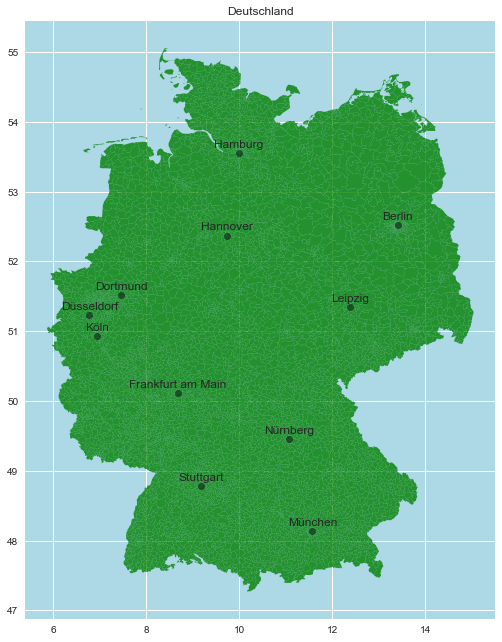

In [7]:
# Following segment is taken and adjusted from https://juanitorduz.github.io/germany_plots/
plt.rcParams['figure.figsize'] = [22, 11]

# Get lat and lng of Germany's main cities. 
top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Köln': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'München': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nürnberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

fig, ax = plt.subplots()

plz_shape.plot(ax=ax, color='green', alpha=0.8)

# Plot cities. 
for c in top_cities.keys():
    # Plot city name.
    ax.text(
        x=top_cities[c][0], 
        # Add small shift to avoid overlap with point.
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )
    # Plot city location centroid.
    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Deutschland', 
    aspect=1.5, 
    facecolor='lightblue'
);

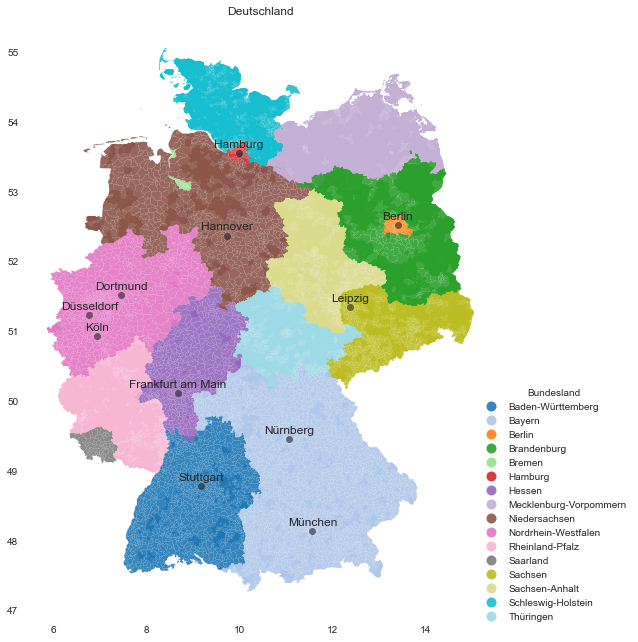

In [8]:
germany_df = pd.merge(
    left=plz_shape, 
    right=plz_region, 
    on='plz',
    how='inner'
)

germany_df.drop(['note'], axis=1, inplace=True)

fig, ax = plt.subplots()

germany_df.plot(
    ax=ax, 
    column='bundesland', 
    categorical=True, 
    legend=True, 
    legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.3, 0.4)},
    cmap='tab20',
    alpha=0.9
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Deutschland', 
    aspect=1.5, 
    facecolor='white'
);

plt.rcParams['figure.figsize'] = [20, 15]

In [9]:

germany_df['jobcount'] = [0 for i in range(len(germany_df))]

for city in loc_cnt_sorted:
    try:
        if germany_df['ort'].str.contains(city[0]).any():
            index = germany_df[germany_df['ort']==city[0]].index
            germany_df.loc[index, 'jobcount'] = city[1]
    except:
        pass


C:\Users\SHARAV~1.SUB\AppData\Local\Temp/ipykernel_7260/286760129.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if germany_df['ort'].str.contains(city[0]).any():


In [10]:
germany_df.head()

,plz,geometry,ort,bundesland,jobcount
0,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",Gangelt,Nordrhein-Westfalen,2
1,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",Selfkant,Nordrhein-Westfalen,0
2,47559,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",Kranenburg,Nordrhein-Westfalen,0
3,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",Heinsberg,Nordrhein-Westfalen,80
4,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",Waldfeucht,Nordrhein-Westfalen,0


###Actual map plotting

In [11]:
germany_df.drop_duplicates(subset='ort', keep='last')
bundesland_df = germany_df.groupby(['bundesland'])[['jobcount']].sum()

for bundesland in bundesland_df.index:
    index = germany_df[germany_df['bundesland']==bundesland].index
    germany_df.loc[index, 'jobcount'] = bundesland_df.loc[bundesland]['jobcount']



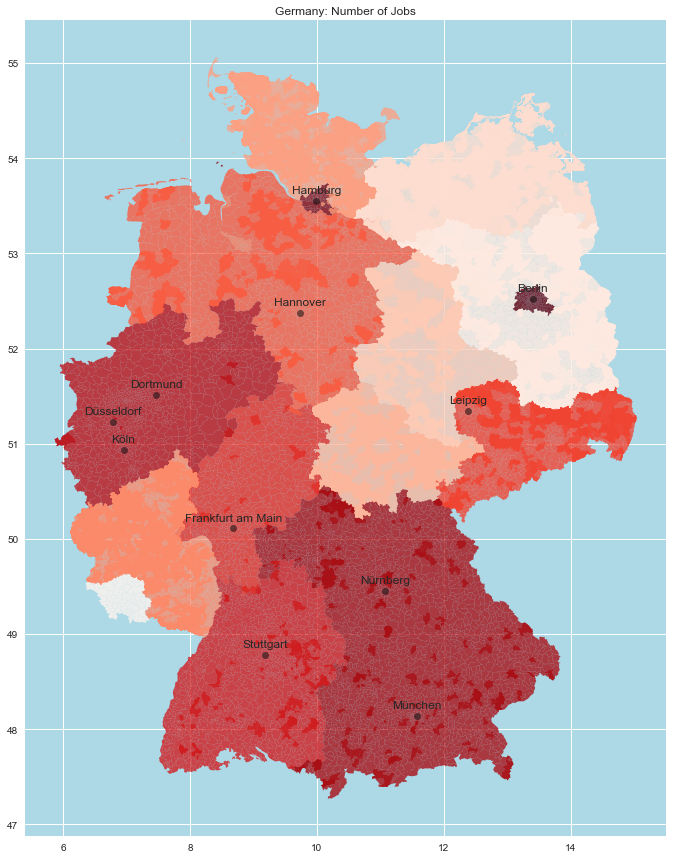

In [13]:
fig, ax = plt.subplots()

germany_df.plot(
    ax=ax, 
    column='jobcount', 
    categorical=True, 
    # legend=germany_df['bundesland'], 
    cmap='Reds',
    alpha=0.8
)

# germany_df.plot(
#     ax=ax, 
#     column='bundesland', 
#     categorical=True, 
#     legend=True, 
#     legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.3, 0.4)},
#     cmap='tab20',
#     alpha=0.9
# )

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Number of Jobs', 
    aspect=1.5, 
    facecolor='lightblue'
);

##Top 20 companies (by offer frequency)

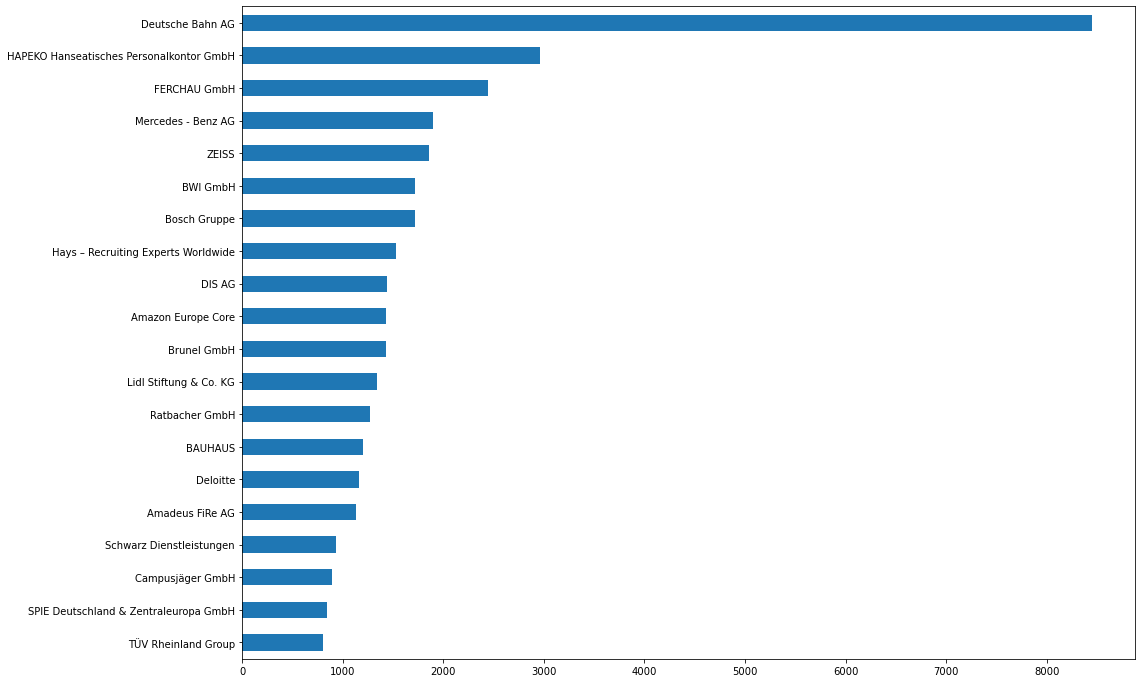

In [6]:
top_company_cnt = df['company'].value_counts()
top20 = top_company_cnt.head(25)
for company in top20.keys():
    if 'Presented' in company:
        top20.drop(company, inplace=True)
top20.head(20).plot.barh()
plt.gca().invert_yaxis()
plt.rcParams['figure.figsize'] = (16, 12)

##Wordcloud prep

In [87]:
weoffer_df = df.weoffer_clean.str.split(expand=True).stack().value_counts().reset_index()
 
weoffer_df.columns = ['Word', 'Frequency'] 
 
weoffer_df.head()

,Word,Frequency
0,und,1482609
1,in,504167
2,mit,423951
3,die,345834
4,der,341438


##Essential functions

In [ ]:
# if type(row) == str and detect(row) == 'de': # lang == True and 

In [17]:
# Count frequency of words in column and tokenize
def countall(col):
    wcnt = Counter()
    stop_words = set(stopwords.words('german'))

    for row in col:
        try:
            tokens = word_tokenize(row, language="german")
            words = [w.lower()  for w in tokens
                                if not w.lower() in stop_words]
            wcnt.update(words)
        except:
            pass

    return wcnt


# Create kode array w/ synonym count of countall()
def synarr(wcnt):
    arr = np.zeros(shape=(8,8))
    r64 = range(64)
    dcnt = {i:0 for i in r64} # dict to count synonym value into
    synonyms = [(syn, i)    for i in r64 
                            for syn in literal_eval(kode['syn'][i])]
    for syn in synonyms:
        sylen = len(syn[0])
        for word in wcnt.keys(): 
            wlen = len(word)
            wlen_ul = wlen + 4
            wlen_ll = wlen - 3
            if wlen_ll <= sylen <= wlen_ul:
                ratio = fuzz.ratio(word.lower(), syn[0])
                if ratio > 80:
                    dcnt[syn[1]] += wcnt[word]
                    del wcnt[word]
                    break
            
    for i in r64:
        x,y = literal_eval(kode['coord'][i])
        arr[x-1][y-1] = dcnt[i]

    return arr


# Sum array into coarser definitions
def coarser(arr):
    cache = []
    result = []
    for j in range(8):
        cache.append([arr[j][i]+arr[j][i+1] for i in range(0, 8, 2)])

    for n in range(0, 8, 2):
        result.append([sum(k) for k in zip(cache[n], cache[n+1])])
        
    return np.array(result)



##Plotting competencies

<AxesSubplot:>

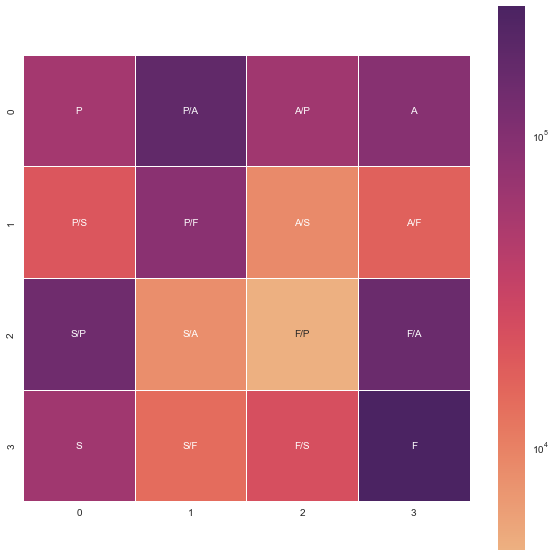

In [18]:
wcnt = countall(df['profile'])
arr = synarr(wcnt)


goho = coarser(arr)
labels = np.array(
    [['P', 'P/A', 'A/P', 'A'],
    ['P/S', 'P/F', 'A/S', 'A/F'],
    ['S/P', 'S/A', 'F/P', 'F/A'],
    ['S', 'S/F', 'F/S', 'F']])

plt.figure(figsize=(10,10))    
sns.heatmap(goho, 
            annot=labels, 
            fmt = '', 
            linewidths=1, 
            linecolor='w', 
            square=True, 
            norm=LogNorm(), # log scale to account for big decrepencies
            cmap='flare')